In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import wandb
import matplotlib.pyplot as plt
import pickle

from scipy.stats import pearsonr
from PIL import Image, ImageDraw
import os

In [ ]:
api = wandb.Api()
fig, ax = plt.subplots();
DPI = fig.dpi
plt.close()

project_viz="<>/vae_visualizations"
project_scores = "<>/vdvae_analysis"

In [3]:
import matplotlib

FONTSIZE = 22
TICK_FONT = {
    "fontsize": 20,
    "fontweight": "normal"
}

def modify_font(fontsize=22, ticksize=20, titlesize=24):
    global FONTSIZE
    global TICK_FONT
    FONTSIZE = fontsize
    TICK_FONT = {
        "fontsize": ticksize,
        "fontweight": "normal"
    }

    matplotlib.rc('font',**{'family':'sans-serif','sans-serif':['Verdana']})
    matplotlib.rc('text', usetex=False)
    matplotlib.rc('font', size=FONTSIZE)
    matplotlib.rc('xtick', labelsize=ticksize)
    matplotlib.rc('ytick', labelsize=ticksize)
    matplotlib.rc('figure', titlesize=titlesize)
    matplotlib.rc('axes', titlesize=titlesize)

modify_font(fontsize=22, ticksize=20, titlesize=24)

# Get data

In [4]:
def _download(file, path, force_redownload=False):
    full_path = os.path.join(path, file.name)
    if os.path.exists(full_path) and not force_redownload:
        return full_path
    else:
        file.download(path, replace=True)
        return full_path

def download_file(run_id, filename, project="<>/vdvae_analysis", force_redownload=False):
    api = wandb.Api()
    run = api.run(f"{project}/{run_id}")
    files = run.files()
    for file in files:
        if file.name == filename:
            return _download(
                file, f"./data/{run_id}/", force_redownload=force_redownload
            )

def get_complexity(run_id):
    path = download_file(run_id, "complexity.pkl")
    df =  pd.read_pickle(path)
    df["compresion_bpd"] = df.compressed_size_t / (256 * 256 * 3)
    return df

def get_sum(data, key):
    for l in range(66):
        k = f"{key}_{l}"
        x = data[k]
        if l == 0:
            x_sum = x
        else:
            x_sum += x
    return x

## fetch data

In [5]:
# complexity
celeba_complexity = get_complexity("<>")
# labels
meta = pd.read_csv("metadata.csv")
# latent stats
path = download_file("<>", "celebahq_latent_stats.pkl")
celeba = pd.read_pickle(path)
# merge all
celeba = pd.merge(celeba, meta, on='idx')
celeba = pd.merge(celeba, celeba_complexity, on='idx')

In [6]:
print("NaN: ", celeba.isna().sum(axis=1).astype(bool).sum())
celeba = celeba[~celeba.isna().sum(axis=1).astype(bool)]

NaN:  1


In [7]:
# add variance sums across 
for k in ["p_var", "q_var"]:
    celeba[f"{k}_sum"] = get_sum(celeba, k)

# Functions

In [8]:
# get mean across group

means_cache = {}

def get_mean_by_layer(data, k, L=66):
    x = []
    s = []
    for i in range(L):
        x.append(np.mean(data[f"{k}_{i}"]))
        s.append(np.std(data[f"{k}_{i}"]))
    return np.array(x), np.array(s)

def get_cached_mean_by_layer(data, k, L=66, label=None, scale_by=None):
    if label is None:
        x, s = get_mean_by_layer(data, k, L=66)
    else:
        key = f"{label}_{k}"
        if key in means_cache:
            x, s =  means_cache[key]
        else:
            x, s = get_mean_by_layer(data, k, L=66)
            means_cache[key] = (x, s)
    if scale_by is not None:
        x = x/scale_by
        s = s/scale_by
    return x, s 

In [9]:
# plotting

def plot_res_change_ticks():
    layers = [0, 2, 6, 11, 21, 43, 57, 65]
    ax = plt.gca()
    ax.set_xticks(layers, minor=False)
    
    plt.xticks(layers, [66-l for l in layers])
    ax.grid(axis='x', which="major", linestyle='--', alpha=0.9)
#     ax.grid( which='both')
    
    return layers

def plot_dist(data, key, layers=(1,2,10, 30, 50, 60)):
    plt.figure(figsize=(8,6))
    for l in layers:
        k = f"{key}_{l}"
        sns.distplot(data[k], kde=False, label=k)
    plt.legend()

colors = list("rgbcmyk") + [f"C{i}" for i in range(0,10)]
# colors = [f"C{i}" for i in range(0,10)]

def get_and_plot_keys(datasets, keys=("qv_mean", "pv_mean"), ci=False, size=5, 
                      logscale=True, scale=False, plot_random=True):
#     colors = [f"C{i}" for i in range(0,8)]
#     lines = ["-", ":", "--", "-."]
    line_pairs = [
        ["-", ":"],
    ]
    n = len(keys)
    fig, axes = plt.subplots(nrows=n, sharex=True, figsize=(2*size,n*size), facecolor="w")
    for i, (ax, k) in enumerate(zip(axes, keys)):
        mx_y = 0
        
        if scale:
#             denom, _ = get_cached_mean_by_layer(ffhq, k, L=66, label="ffhq")
            denom, _ = get_cached_mean_by_layer(celeba, k, L=66, label="celeba")
#             denom += 1e-8
        else:
            denom = None
        for j, groups in enumerate(datasets):
            c = colors[j % len(colors)]
            lines = line_pairs[j // len(colors)]
            for jj, (d, l) in enumerate(groups):
                lin = lines[jj % len(lines)]
                x, s = get_cached_mean_by_layer(d, k, L=66, label=l, scale_by=denom)
                mx_y = max(max(x), mx_y)
                if ci:
                    ax.fill_between(np.arange(len(x)), x-2*s,x+2*s, color=c, alpha=0.1)
                ax.plot(x, c + lin, label=l)
                
        ax.text(0, mx_y, k, fontsize=16)
#         if i == 0:
#             ax.legend()
        if logscale:
            ax.set_yscale("log")
            
        plt.sca(ax)
        layers = plot_res_change_ticks()
        
        plt.ylabel("relative difference")
        
        if plot_random:
            rmin, _ = get_cached_mean_by_layer(d, k, L=66, label="random_min", scale_by=denom)
            rmax, _ = get_cached_mean_by_layer(d, k, L=66, label="random_max", scale_by=denom)
            ax.fill_between(np.arange(len(rmin)), rmin,rmax, color='grey', alpha=0.4)
#             ax.plot(rmin, color='grey')
#             ax.plot(rmax, color='grey')

#     plot_res_change_ticks()
    plt.xlabel("latent layer")
    plt.subplots_adjust(hspace=.0)

In [10]:
def plot_features(features, keys=("q_var","p_var"), size=7, logscale=True):
    datasets = []
    for feature in features:
        datasets.append([(celeba[celeba[feature] == 1], f"{feature}"),
                         (celeba[celeba[feature] == -1], f"not_{feature}")])
    get_and_plot_keys(datasets, 
                  keys=keys, ci=False, logscale=logscale, size=size, scale=True)

In [11]:
from matplotlib.patches import Patch
from matplotlib.lines import Line2D

def custom_legend(features, loc=None):
    legend_elements = [
                           Line2D([0], [0],
                                  color=colors[i],
                                  linestyle='-',
                                  label=f,
                            ) for i, f in enumerate(features)
                           

    ] + [
         Line2D([0], [0],
                  color='k',
                  linestyle=':',
                  label='lack of specific attribute'),
        Patch(
            facecolor='grey',
            edgecolor='grey',
            alpha=0.4,
            label='Bootstrapped range'),
    ]

    plt.legend(handles=legend_elements, loc=loc)

In [12]:
def set_yticks(step=0.05):
    yticks = list(np.arange(0,1.01,step))
    ax = plt.gca()
    ax.set_yticks(yticks, minor=True)
    ax.grid(axis='y', which="both", linestyle='--', alpha=0.5)
#     ax.grid(axis='y', which="major", linestyle='-', alpha=0.7)

# get random

In [ ]:
all_r = {}
max_r = {}
min_r = {}
for k in ("p_var", "q_var"):
    inds = []
    all_random = []
    for i in range(1000):
        df = celeba.sample(n=1000, random_state=i)
        x, s = get_mean_by_layer(df, k, L=66)
        all_random.append(x)
    all_r[k] = np.array(all_random)
    max_r[k] = all_r[k].max(axis=0)
    min_r[k] = all_r[k].min(axis=0)
    
    means_cache[f'random_min_{k}'] = (min_r[k], np.zeros_like(s))
    means_cache[f'random_max_{k}'] = (max_r[k], np.zeros_like(s))
    

# Variance analysis

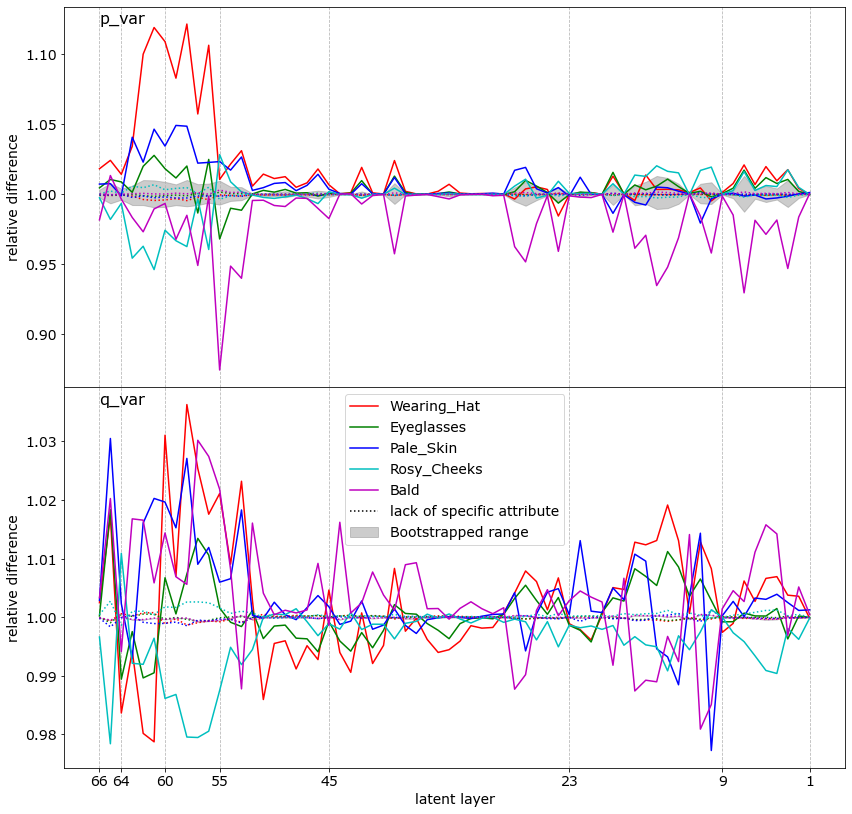

In [14]:
features = [
 'Wearing_Hat',# <
#  'Gray_Hair',
 'Eyeglasses',# <
 'Pale_Skin', # <
#  'Mustache',
#  'Chubby', # rev
#  'Wearing_Necktie',
#  'Goatee',
#  'Sideburns',
#  "Male",# ? 
    'Rosy_Cheeks',# <
#  'Narrow_Eyes',
#  'Bushy_Eyebrows',
    "Bald",# ?
#     "Bangs"
    
]
modify_font(fontsize=14, ticksize=14, titlesize=18)
plot_features(features, keys=("p_var", "q_var"), logscale=False)
custom_legend(features)
plt.savefig("fig/rare_feature_variance.pdf", bbox_inches='tight')

# 2.3 Classification

In [15]:
score_lines = {
    'pv': ':',
    'qv': ':',
    'pm': '-',
    'qm': '-',
    'z': '-',
    "p_var": '-', 
    "q_var": '-', 
    "var_diff_sq": ':',
}
score_colors = {
    'pv': 'C0',
    'qv': 'C1',
    'pm': 'teal',
    'qm': 'orangered',
    'z': 'k',
    "p_var": 'C0', 
    "q_var": 'C1', 
    "var_diff_sq": 'C2',
}

In [16]:
api = wandb.Api()

modify_font(fontsize=22, ticksize=20, titlesize=24)

In [17]:
def get_history_for_run(run_id):
    run = api.run(f'<>/vdvae_analysis/{run_id}')
    return run.history()

runs = {
    "qm": "",
    "pm": "",
    "qv": "",
    "pv": "",
}
runs_grouped = {    
    "qm": "",
    "pm": "",
    "qv": "",
    "pv": "",
}
data = {}
data_grouped = {}

for k, run_id in runs.items():
    data[k] = get_history_for_run(run_id)
    
for k, run_id in runs_grouped.items():
    data_grouped[k] = get_history_for_run(run_id)

In [18]:
# stat_colors = {
#     "pm": "C1",
#     "pv": "C2",
#     "qm": "C3",
#     "qv": "C4"
# }

stat_labels = {
    "pm": "p_mean",
    "pv": "p_var",
    "qm": "q_mean",
    "qv": "q_var"
}

def plot_res_change_ticks_small():
    layers_major = [0, 6, 11, 21, 43, 57, 65]
    layers_minor = [0, 2, 6, 11, 21, 43, 57, 65]
    ax = plt.gca()
    ax.set_xticks(layers_minor, minor=True)
    ax.set_xticks(layers_major, minor=False)
    
    plt.xticks(layers_major, [66-l for l in layers_major])
    ax.grid(axis='x', which="minor", linestyle='--', alpha=0.9)
    ax.grid(axis='x', which="major", linestyle='--', alpha=0.9)

def plot_key(data, key, legend=True, legend_loc=None, title_suffix=""):
    plt.figure(figsize=(9,6))

    for k, df in data.items():
        plt.plot(df[f'{key}_roc_auc_score'], 
                 color=score_colors[k], linestyle=score_lines[k], 
                 label=f'KNN({k})');
    
    plot_res_change_ticks_small()
    
    plt.ylabel("AUROC")
    plt.xlabel("latent layer")
    plt.plot([0,60], [0.5,0.5], 'k:', alpha=0.5)
    if legend:
        plt.legend(loc=legend_loc)
    set_yticks(step=0.1)
    plt.ylim((0.4,1))
#     plt.title(f'"{key}"')
    plt.title(f"{key}{title_suffix}")

In [ ]:
plot_key(data, "Male", legend=None, legend_loc=(0.9, 0.6))
plt.savefig("fig/classify_male.pdf")

In [ ]:
plot_key(data_grouped, "Wearing_Hat", title_suffix=" (grouped)", legend=False)
plt.savefig("fig/classify_hat.pdf")

In [ ]:
plot_key(data_grouped, "f_Heavy_Makeup", legend=None, legend_loc=(0.2, 0.01), title_suffix=" (female only)")
plt.savefig("fig/classify_makeup.pdf")

In [ ]:
plot_key(data_grouped, "Young", legend_loc=(0.6, 0.55), title_suffix=" (grouped)")
plt.savefig("fig/classify_young.pdf")

# 2.4 Anomaly detection

In [19]:
from sklearn.metrics import roc_auc_score

def get_aucroc(ind, ood, key):
    scores = []
    for l in range(66):
        k = f"{key}_{l}"
        x_in = ind[k]
        x_out = ood[k]
        y_in = np.zeros_like(x_in)
        y_out = np.ones_like(x_out)
        x = np.concatenate([x_in, x_out])
        y = np.concatenate([y_in, y_out]).astype(bool)
        scores.append(roc_auc_score(y, x))
    return np.array(scores)


def get_aucroc_single(ind, ood, k):
    x_in = ind[k]
    x_out = ood[k]
    y_in = np.zeros_like(x_in)
    y_out = np.ones_like(x_out)
    x = np.concatenate([x_in, x_out])
    y = np.concatenate([y_in, y_out]).astype(bool)
    return roc_auc_score(y, x)

def get_aucroc_from_sum(ind, ood, key):
    scores = []
    for l in range(66):
        k = f"{key}_{l}"
        x_in = ind[k]
        x_out = ood[k]
        x = np.concatenate([x_in, x_out])
        if l == 0:
            x_sum = x
            y_in = np.zeros_like(x_in)
            y_out = np.ones_like(x_out)
            y = np.concatenate([y_in, y_out]).astype(bool)
        else:
            x_sum += x
    return roc_auc_score(y, x_sum)

In [20]:



def classify(feature, score_data, keys=("p_var",), score_key="roc_auc_score_avg", 
             legend=True, legend_loc=None, title_suffix="", group=None):
    plt.figure(figsize=(10, 6), facecolor="w")
    
    print(feature)    
    mask_in = (celeba[feature] == -1) 
    mask_out = (celeba[feature] == 1) 
    mask_male =  (celeba["Male"] == 1)
    mask_female = (celeba["Male"] == -1)
    
    in_label = f"not_{feature}"
    out_label = feature

    # unsupervised
    for k in keys:
#         print(k, get_aucroc_from_sum(df_in, df_out, k))
        if group == 'm':
            result = get_aucroc(celeba[mask_in & mask_male], celeba[mask_out & mask_male], k)
        if group == 'f':
            result = get_aucroc(celeba[mask_in & mask_female], celeba[mask_out & mask_female], k)
        if group == "avg" or group == True:
            result_m = get_aucroc(celeba[mask_in & mask_male], celeba[mask_out & mask_male], k)
            result_f = get_aucroc(celeba[mask_in & mask_female], celeba[mask_out & mask_female], k)
            result = (result_m + result_f) / 2
        else:
            result = get_aucroc(celeba[mask_in], celeba[mask_out], k)
            
        plt.plot(result, 
                 color=score_colors[k], linestyle=score_lines[k], 
                 label=k)

    # supervised
    for k, scores in score_data.items():
        if group == 'f':
            key = f'f_{feature}_{score_key}'
        elif group == 'm':
            key = f'm_{feature}_{score_key}'
        else:
            key = f'{feature}_{score_key}'
        plt.plot(scores[key].index, scores[key],  
                 color=score_colors[k], linestyle=score_lines[k], 
                 label=f'KNN({k})');
    
    plot_res_change_ticks_small()
    plt.ylabel("AUROC")
    plt.xlabel("latent layer")
    plt.plot([0,60], [0.5,0.5], 'k:', alpha=0.5)
    if legend:
        plt.legend(loc=legend_loc)
    set_yticks(step=0.1)
    plt.ylim((0,1))
#     plt.title(f'"{key}"')
    plt.title(f"{feature}{title_suffix}")
#     plt.title(f"{in_label} (in) vs {out_label} (out) OOD detection")

In [21]:
score_lines = {
    'pv': ':',
    'qv': ':',
    'pm': '--',
    'qm': '--',
    'z': '-',
    "p_var": '-', 
    "q_var": '-', 
    "var_diff_sq": ':',
}

In [22]:
def s(d, ks):
    return {k: v for k,v in d.items() if k in ks}

Male


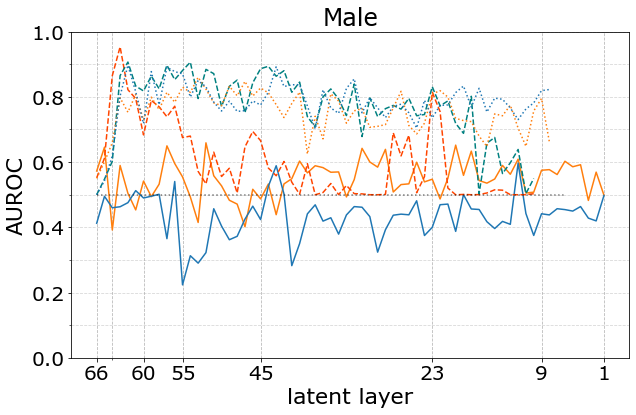

In [23]:
# classify("Male", s(data, ['qv', 'pv']) , keys=["q_var", "p_var"], score_key="roc_auc_score",
#          legend=False, legend_loc=None, title_suffix="")
# plt.savefig("fig/detect_male.pdf", bbox_inches='tight')
classify("Male", s(data, ['qv', 'pv', 'qm', 'pm']) , keys=["q_var", "p_var"], score_key="roc_auc_score",
         legend=False, legend_loc=None, title_suffix="")
plt.savefig("fig/detectall_male.pdf", bbox_inches='tight')

Wearing_Hat


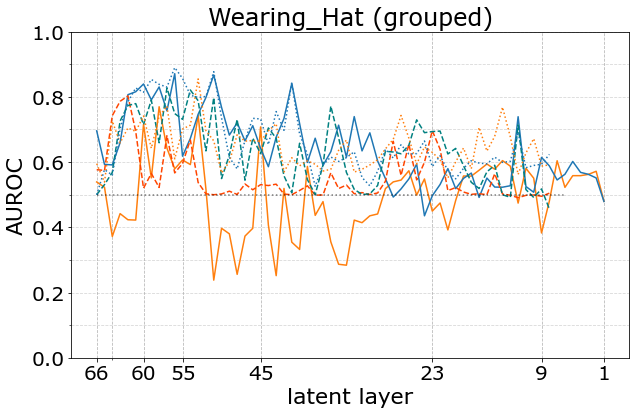

In [24]:
# classify("Wearing_Hat", s(data_grouped, ['qv', 'pv']) , keys=["q_var", "p_var"], score_key="roc_auc_score",
#          legend=False, legend_loc=None, title_suffix=" (grouped)", group=True)
# plt.savefig("fig/detect_hat.pdf", bbox_inches='tight')
classify("Wearing_Hat", s(data_grouped, ['qv', 'pv', 'qm', 'pm']) , keys=["q_var", "p_var"], score_key="roc_auc_score",
         legend=False, legend_loc=None, title_suffix=" (grouped)", group=True)
plt.savefig("fig/detectall_hat.pdf", bbox_inches='tight')

Young


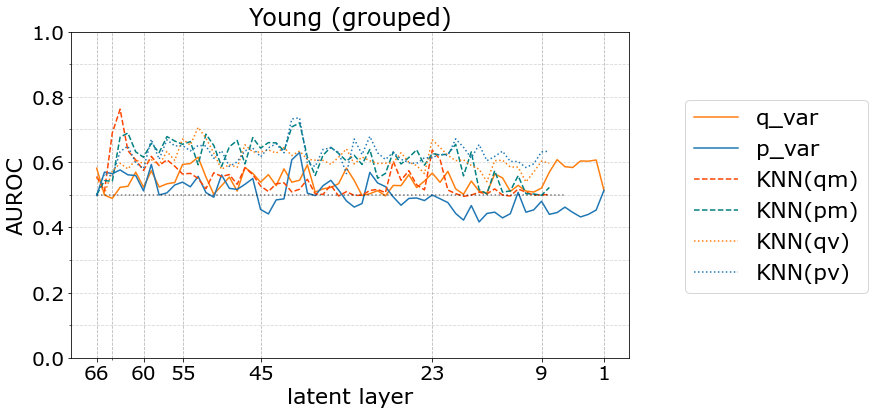

In [25]:
# classify("Young", s(data_grouped, ['qv', 'pv']) , keys=["q_var", "p_var"], score_key="roc_auc_score",
#          legend=True, legend_loc=None, title_suffix=" (grouped)", group=True)
# plt.savefig("fig/detect_young.pdf", bbox_inches='tight')
classify("Young", s(data_grouped, ['qv', 'pv', 'qm', 'pm']) , keys=["q_var", "p_var"], score_key="roc_auc_score",
         legend=True, legend_loc=(1.1,0.2), title_suffix=" (grouped)", group=True)
plt.savefig("fig/detectall_young.pdf", bbox_inches='tight')

Bald


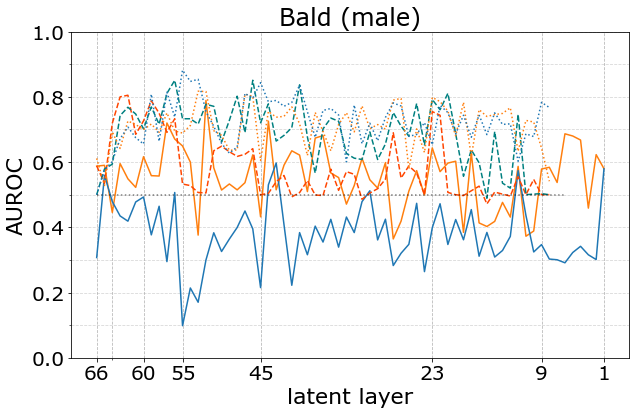

In [26]:
# classify("Bald", s(data_grouped, ['qv', 'pv']) , keys=["q_var", "p_var"], score_key="roc_auc_score",
#          legend=False, legend_loc=None, title_suffix=" (male)", group="m")
# plt.savefig("fig/detect_bald.pdf", bbox_inches='tight')
classify("Bald", s(data_grouped, ['qv', 'pv', 'qm', 'pm']) , keys=["q_var", "p_var"], score_key="roc_auc_score",
         legend=False, legend_loc=None, title_suffix=" (male)", group="m")
plt.savefig("fig/detectall_bald.pdf", bbox_inches='tight')

Pale_Skin


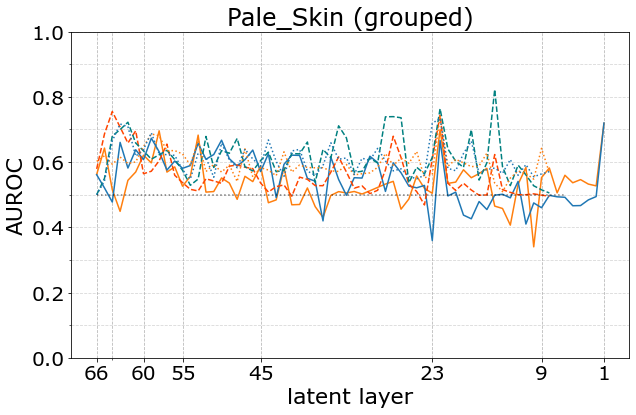

In [27]:
# classify("Pale_Skin", s(data_grouped, ['qv', 'pv']) , keys=["q_var", "p_var"], score_key="roc_auc_score",
#          legend=False, legend_loc=None, title_suffix=" (grouped)", group=True)
# plt.savefig("fig/detect_pale.pdf", bbox_inches='tight')
classify("Pale_Skin", s(data_grouped, ['qv', 'pv', 'qm', 'pm']) , keys=["q_var", "p_var"], score_key="roc_auc_score",
         legend=False, legend_loc=None, title_suffix=" (grouped)", group=True)
plt.savefig("fig/detectall_pale.pdf", bbox_inches='tight')

Heavy_Makeup


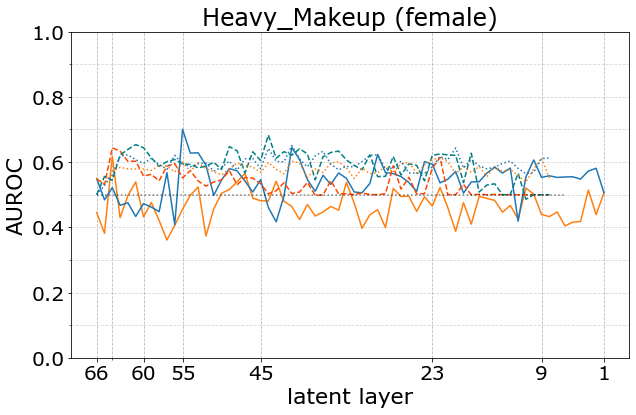

In [28]:
# classify("Heavy_Makeup", s(data_grouped, ['qv', 'pv']) , keys=["q_var", "p_var"], score_key="roc_auc_score",
#          legend=False, legend_loc=None, title_suffix=" (female)", group="f")
# plt.savefig("fig/detect_makeup.pdf", bbox_inches='tight')
classify("Heavy_Makeup", s(data_grouped, ['qv', 'pv', 'qm', 'pm']) , keys=["q_var", "p_var"], score_key="roc_auc_score",
         legend=False, legend_loc=None, title_suffix=" (female)", group="f")
plt.savefig("fig/detectall_makeup.pdf", bbox_inches='tight')

Rosy_Cheeks


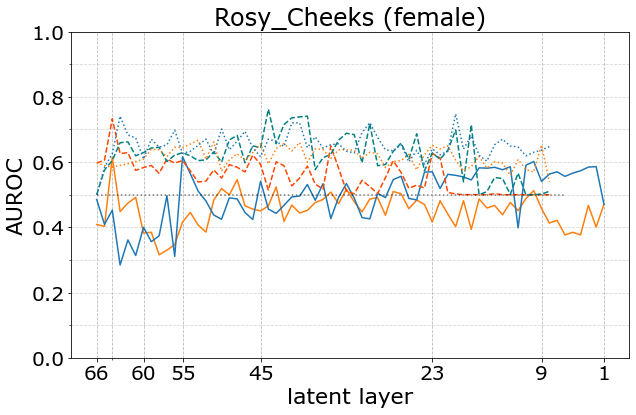

In [42]:
classify("Rosy_Cheeks", s(data_grouped, ['qv', 'pv', 'qm', 'pm']) , keys=["q_var", "p_var"], score_key="roc_auc_score",
         legend=False, legend_loc=None, title_suffix=" (female)", group="f")
plt.savefig("fig/detectall_cheeks.pdf", bbox_inches='tight')

Eyeglasses


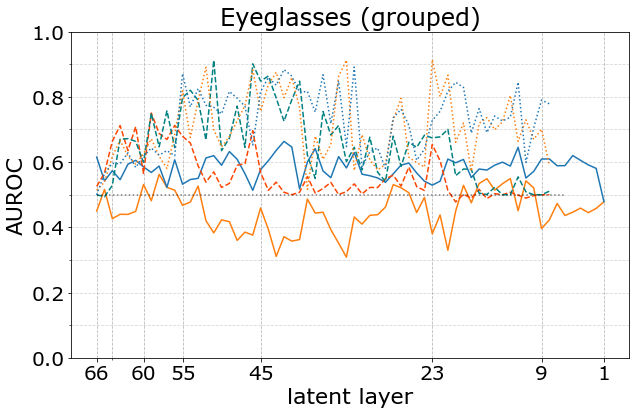

In [37]:
classify("Eyeglasses", s(data_grouped, ['qv', 'pv', 'qm', 'pm']) , keys=["q_var", "p_var"], score_key="roc_auc_score",
         legend=False, legend_loc=None, title_suffix=" (grouped)", group=True)
plt.savefig("fig/detectall_eyeglasses.pdf", bbox_inches='tight')

Smiling


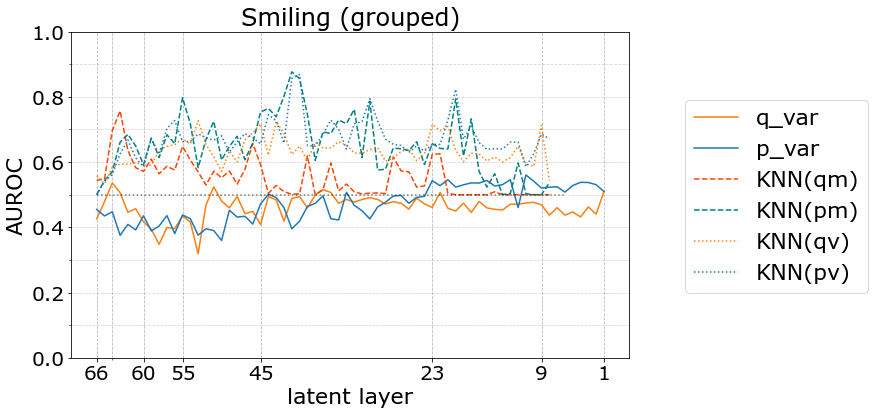

In [41]:
classify("Smiling", s(data_grouped, ['qv', 'pv', 'qm', 'pm']) , keys=["q_var", "p_var"], score_key="roc_auc_score",
         legend=True, legend_loc=(1.1,0.2), title_suffix=" (grouped)", group=True)
plt.savefig("fig/detectall_smiling.pdf", bbox_inches='tight')

In [ ]:
# bootstrapped significance ?

In [ ]:
classify("Pale_Skin", s(data_grouped, ['qv', 'pv']) , keys=["q_var", "p_var"], score_key="roc_auc_score",
         legend=False, legend_loc=None, title_suffix=" (grouped)", group=True)
for i in range(1000):
    for k in ["q_var", "p_var"]:
            n = np.random.randint(800, 3000)
            ind_out = celeba.sample(n).index
            mask_out = celeba.index.isin(ind_out)
            result = get_aucroc(celeba[~mask_out], celeba[mask_out], k)    
            plt.plot(result, 
                     color=score_colors[k], linestyle=score_lines[k], 
#                      label=f'{k} - {i}'
                    )
# plt.legend()


# avg and complexity

In [76]:
from sklearn.metrics import roc_auc_score

def get_aucroc(ind, ood, key, correct=False):
    scores = []
    for l in range(66):
        k = f"{key}_{l}"
        x_in = ind[k]
        x_out = ood[k]
        
        if correct:
            comps_in = ind.compresion_bpd
            comps_out = ood.compresion_bpd
            z = np.polyfit(comps_in, x_in, 1)
            ref_p = np.poly1d(z)
            x_in = x_in - ref_p(comps_in)
            x_out = x_out - ref_p(comps_out)
        
        y_in = np.zeros_like(x_in)
        y_out = np.ones_like(x_out)
        x = np.concatenate([x_in, x_out])
        y = np.concatenate([y_in, y_out]).astype(bool)
        scores.append(roc_auc_score(y, x))
    return np.array(scores)

def get_aucroc_from_sum(ind, ood, key, correct=False):
    scores = []
    for l in range(66):
        k = f"{key}_{l}"
        x_in = ind[k]
        x_out = ood[k]
        
        if correct:
            comps_in = ind.compresion_bpd
            comps_out = ood.compresion_bpd
            z = np.polyfit(comps_in, x_in, 1)
            ref_p = np.poly1d(z)
            x_in = x_in - ref_p(comps_in)
            x_out = x_out - ref_p(comps_out)
        
        x = np.concatenate([x_in, x_out])
        if l == 0:
            x_sum = x
            y_in = np.zeros_like(x_in)
            y_out = np.ones_like(x_out)
            y = np.concatenate([y_in, y_out]).astype(bool)
        else:
            x_sum += x
    return roc_auc_score(y, x_sum)

In [79]:

def classify2(feature, score_data, keys=("p_var",), score_key="roc_auc_score_avg", 
             legend=True, legend_loc=None, title_suffix="", group=None, avg=True):
    plt.figure(figsize=(10, 6), facecolor="w")
    
    print(feature)    
    mask_in = (celeba[feature] == -1) 
    mask_out = (celeba[feature] == 1) 
    mask_male =  (celeba["Male"] == 1)
    mask_female = (celeba["Male"] == -1)
    
    in_label = f"not_{feature}"
    out_label = feature

    # unsupervised
    for k in keys:
#         print(k, get_aucroc_from_sum(df_in, df_out, k))
        if group == 'm':
            result = get_aucroc(celeba[mask_in & mask_male], celeba[mask_out & mask_male], k)
            result_corr = get_aucroc(celeba[mask_in & mask_male], celeba[mask_out & mask_male], k, correct=True)
            result_sum = get_aucroc_from_sum(celeba[mask_in & mask_male], celeba[mask_out & mask_male], k, correct=True)
        if group == 'f':
            result = get_aucroc(celeba[mask_in & mask_female], celeba[mask_out & mask_female], k)
            result_corr = get_aucroc(celeba[mask_in & mask_female], celeba[mask_out & mask_female], k, correct=True)
            result_sum = get_aucroc_from_sum(celeba[mask_in & mask_female], celeba[mask_out & mask_female], k, correct=True)
        if group == "avg" or group == True:
            result_m = get_aucroc(celeba[mask_in & mask_male], celeba[mask_out & mask_male], k)
            result_f = get_aucroc(celeba[mask_in & mask_female], celeba[mask_out & mask_female], k)
            result = (result_m + result_f) / 2
            
            result_m_corr = get_aucroc(celeba[mask_in & mask_male], celeba[mask_out & mask_male], k, correct=True)
            result_f_corr = get_aucroc(celeba[mask_in & mask_female], celeba[mask_out & mask_female], k, correct=True)
            result_corr = (result_m_corr + result_f_corr) / 2
            
            result_m_sum = get_aucroc_from_sum(celeba[mask_in & mask_male], celeba[mask_out & mask_male], k, correct=True)
            result_f_sum = get_aucroc_from_sum(celeba[mask_in & mask_female], celeba[mask_out & mask_female], k, correct=True)
            result_sum = (result_m_sum + result_f_sum) / 2
        else:
            result = get_aucroc(celeba[mask_in], celeba[mask_out], k)
            result_corr = get_aucroc(celeba[mask_in], celeba[mask_out], k, correct=True)
            result_sum = get_aucroc_from_sum(celeba[mask_in], celeba[mask_out], k, correct=True)
            
        plt.plot(result, 
                 color=score_colors[k], linestyle=score_lines[k], 
                 label=k)
        plt.plot(result_corr, 
                 color=score_colors[k], linestyle="-.", 
                 label=k)
        if avg:
            plt.plot([0, 66], [result_sum, result_sum], 
                     color=score_colors[k], linestyle='--', 
                     label=f'{k} (avg)')

    # supervised
    for k, scores in score_data.items():
        if group == 'f':
            key = f'f_{feature}_{score_key}'
        elif group == 'm':
            key = f'm_{feature}_{score_key}'
        else:
            key = f'{feature}_{score_key}'
        plt.plot(scores[key].index, scores[key],  
                 color=score_colors[k], linestyle=score_lines[k], 
                 label=f'KNN({k})');
    
    plot_res_change_ticks_small()
    plt.ylabel("AUROC")
    plt.xlabel("latent layer")
    plt.plot([0,60], [0.5,0.5], 'k:', alpha=0.5)
    if legend:
        plt.legend(loc=legend_loc)
    set_yticks(step=0.1)
    plt.ylim((0,1))
#     plt.title(f'"{key}"')
    plt.title(f"{feature}{title_suffix}")
#     plt.title(f"{in_label} (in) vs {out_label} (out) OOD detection")

Male


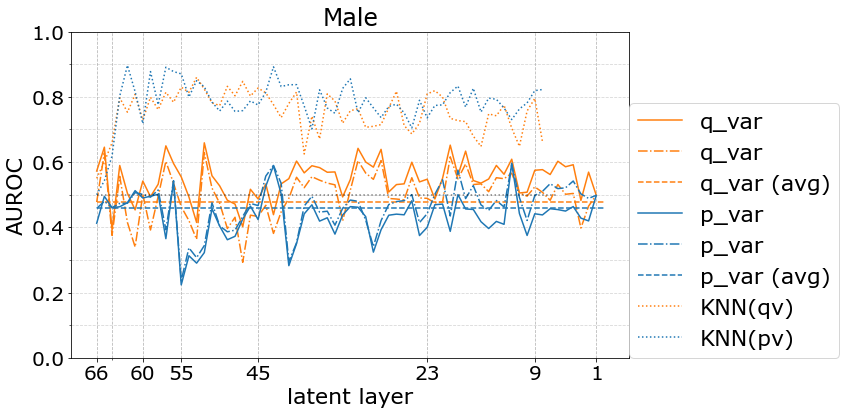

In [80]:
classify2("Male", s(data, ['qv', 'pv']) , keys=["q_var", "p_var"], score_key="roc_auc_score",
         legend=True, legend_loc=(1,0), title_suffix="")
# plt.savefig("fig/detect_male.pdf", bbox_inches='tight')

Male


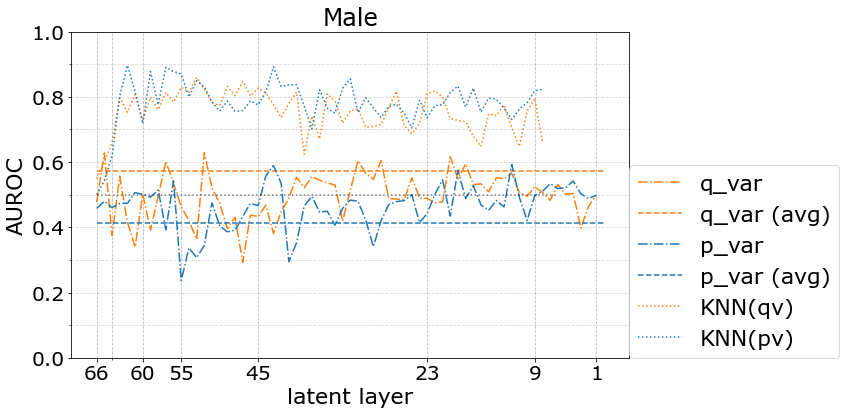

In [78]:
classify2("Male", s(data, ['qv', 'pv']) , keys=["q_var", "p_var"], score_key="roc_auc_score",
         legend=True, legend_loc=(1,0), title_suffix="")
# plt.savefig("fig/detect_male.pdf", bbox_inches='tight')

Heavy_Makeup


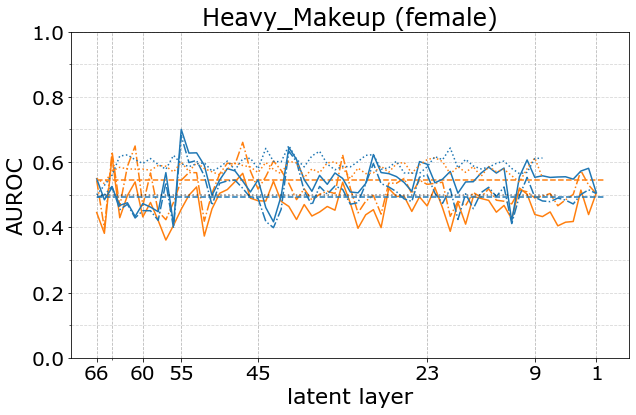

In [81]:
classify2("Heavy_Makeup", s(data_grouped, ['qv', 'pv']) , keys=["q_var", "p_var"], score_key="roc_auc_score",
         legend=False, legend_loc=None, title_suffix=" (female)", group="f")

Wearing_Hat


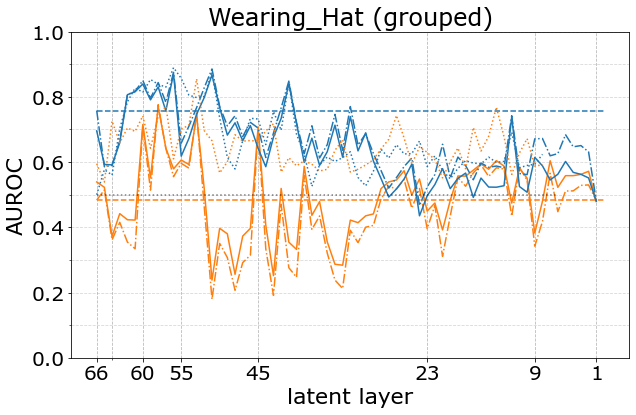

In [82]:
classify2("Wearing_Hat", s(data_grouped, ['qv', 'pv']) , keys=["q_var", "p_var"], score_key="roc_auc_score",
         legend=False, legend_loc=None, title_suffix=" (grouped)", group=True)
# plt.savefig("fig/detect_hat.pdf", bbox_inches='tight')

In [85]:
score_lines = {
    'pv': ':',
    'qv': ':',
    'pm': '--',
    'qm': '--',
    'z': '-',
    "p_var": '-', 
    "q_var": '-', 
    "var_diff_sq": ':',
}

Male


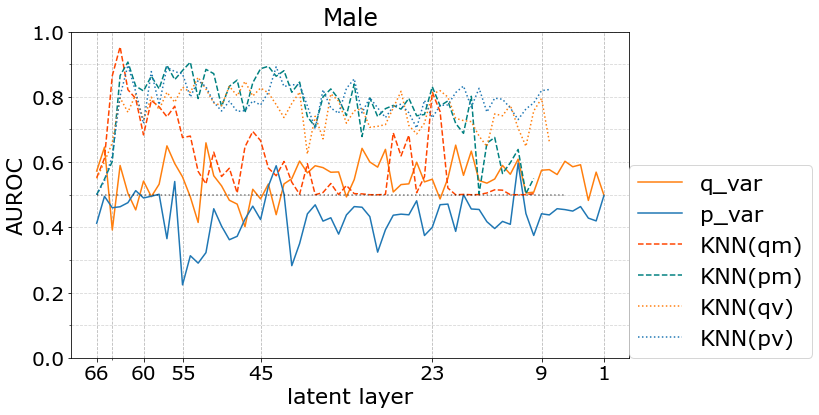

In [86]:
classify("Male", s(data, ['qv', 'pv', 'qm', 'pm']) , keys=["q_var", "p_var"], score_key="roc_auc_score",
         legend=True, legend_loc=(1,0), title_suffix="")
# plt.savefig("fig/detect_male.pdf", bbox_inches='tight')